In [67]:
import torch
import matplotlib.pyplot as plt
import random
import h5py
import os

from diffusers import DDPMScheduler, DDIMScheduler
from model import TemporalUnet

model: TemporalUnet = torch.load("model.pt")
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    clip_sample_range=3.0
)

path = "auto"
if path == "auto":
    paths = [path for path in os.listdir(".") if path.endswith(".h5py")]
    paths.sort()
    path = paths[-1]
    print(f"Using {path} as path to hdf5 file.")

dataset = h5py.File(path, "r")
cursor = dataset.attrs["cursor"]
policy_control_start = dataset["control_mode"][:].nonzero()[0][0]
print(list(dataset.keys()))
print(cursor, policy_control_start)

Using 11-10_23-04-05.h5py as path to hdf5 file.
['action', 'angvel', 'command', 'control_mode', 'jpos', 'jpos_des', 'jvel', 'linvel', 'observation', 'quat', 'rpy', 'tau_est']
2999 373


/tmp/ipykernel_62846/2244143074.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TemporalUnet = torch.load("model.pt")


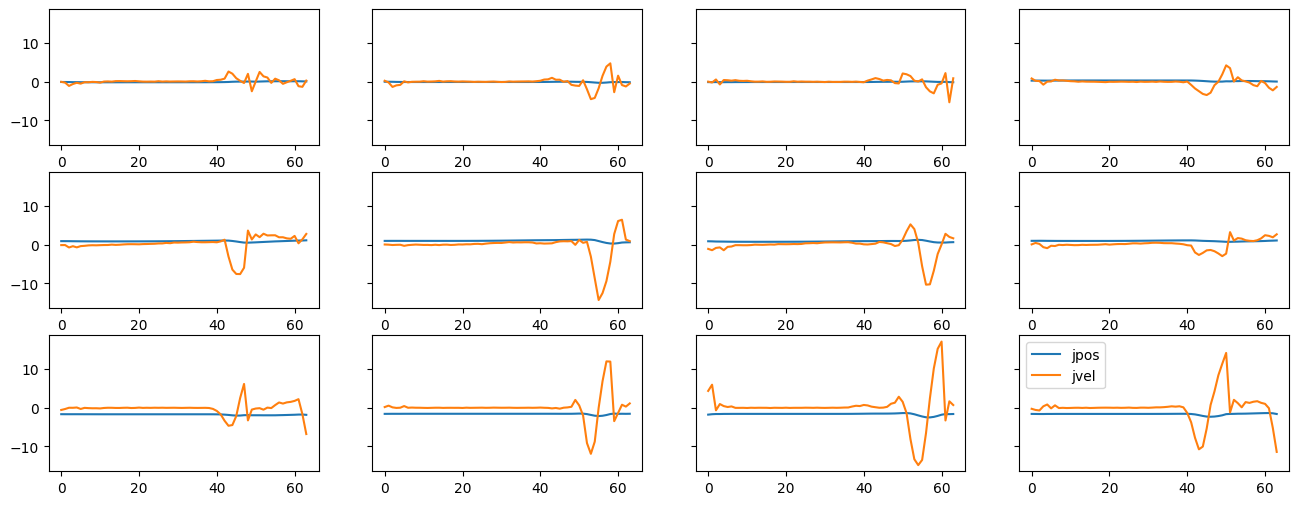

In [68]:

start = policy_control_start + random.randint(0, 200)
end = start + 64
jpos = dataset["jpos"][start: end]
jpos_des = dataset["jpos_des"][start: end]
jvel = dataset["jvel"][start: end]
action = dataset["action"][start: end]
obs = dataset["observation"][start: end]

fig, axes = plt.subplots(3, 4, figsize=(16, 6), sharey=True)
axes = axes.reshape(-1)
for i in range(12):
    ax = axes[i]
    ax.plot(jpos[:, i], label="jpos")
    # ax.plot(jpos_des[:, i])
    ax.plot(jvel[:, i], label="jvel")
    # ax.plot((jpos[1:, i] - jpos[:1, i]) / 0.02, label="jvel_diff")
ax.legend()

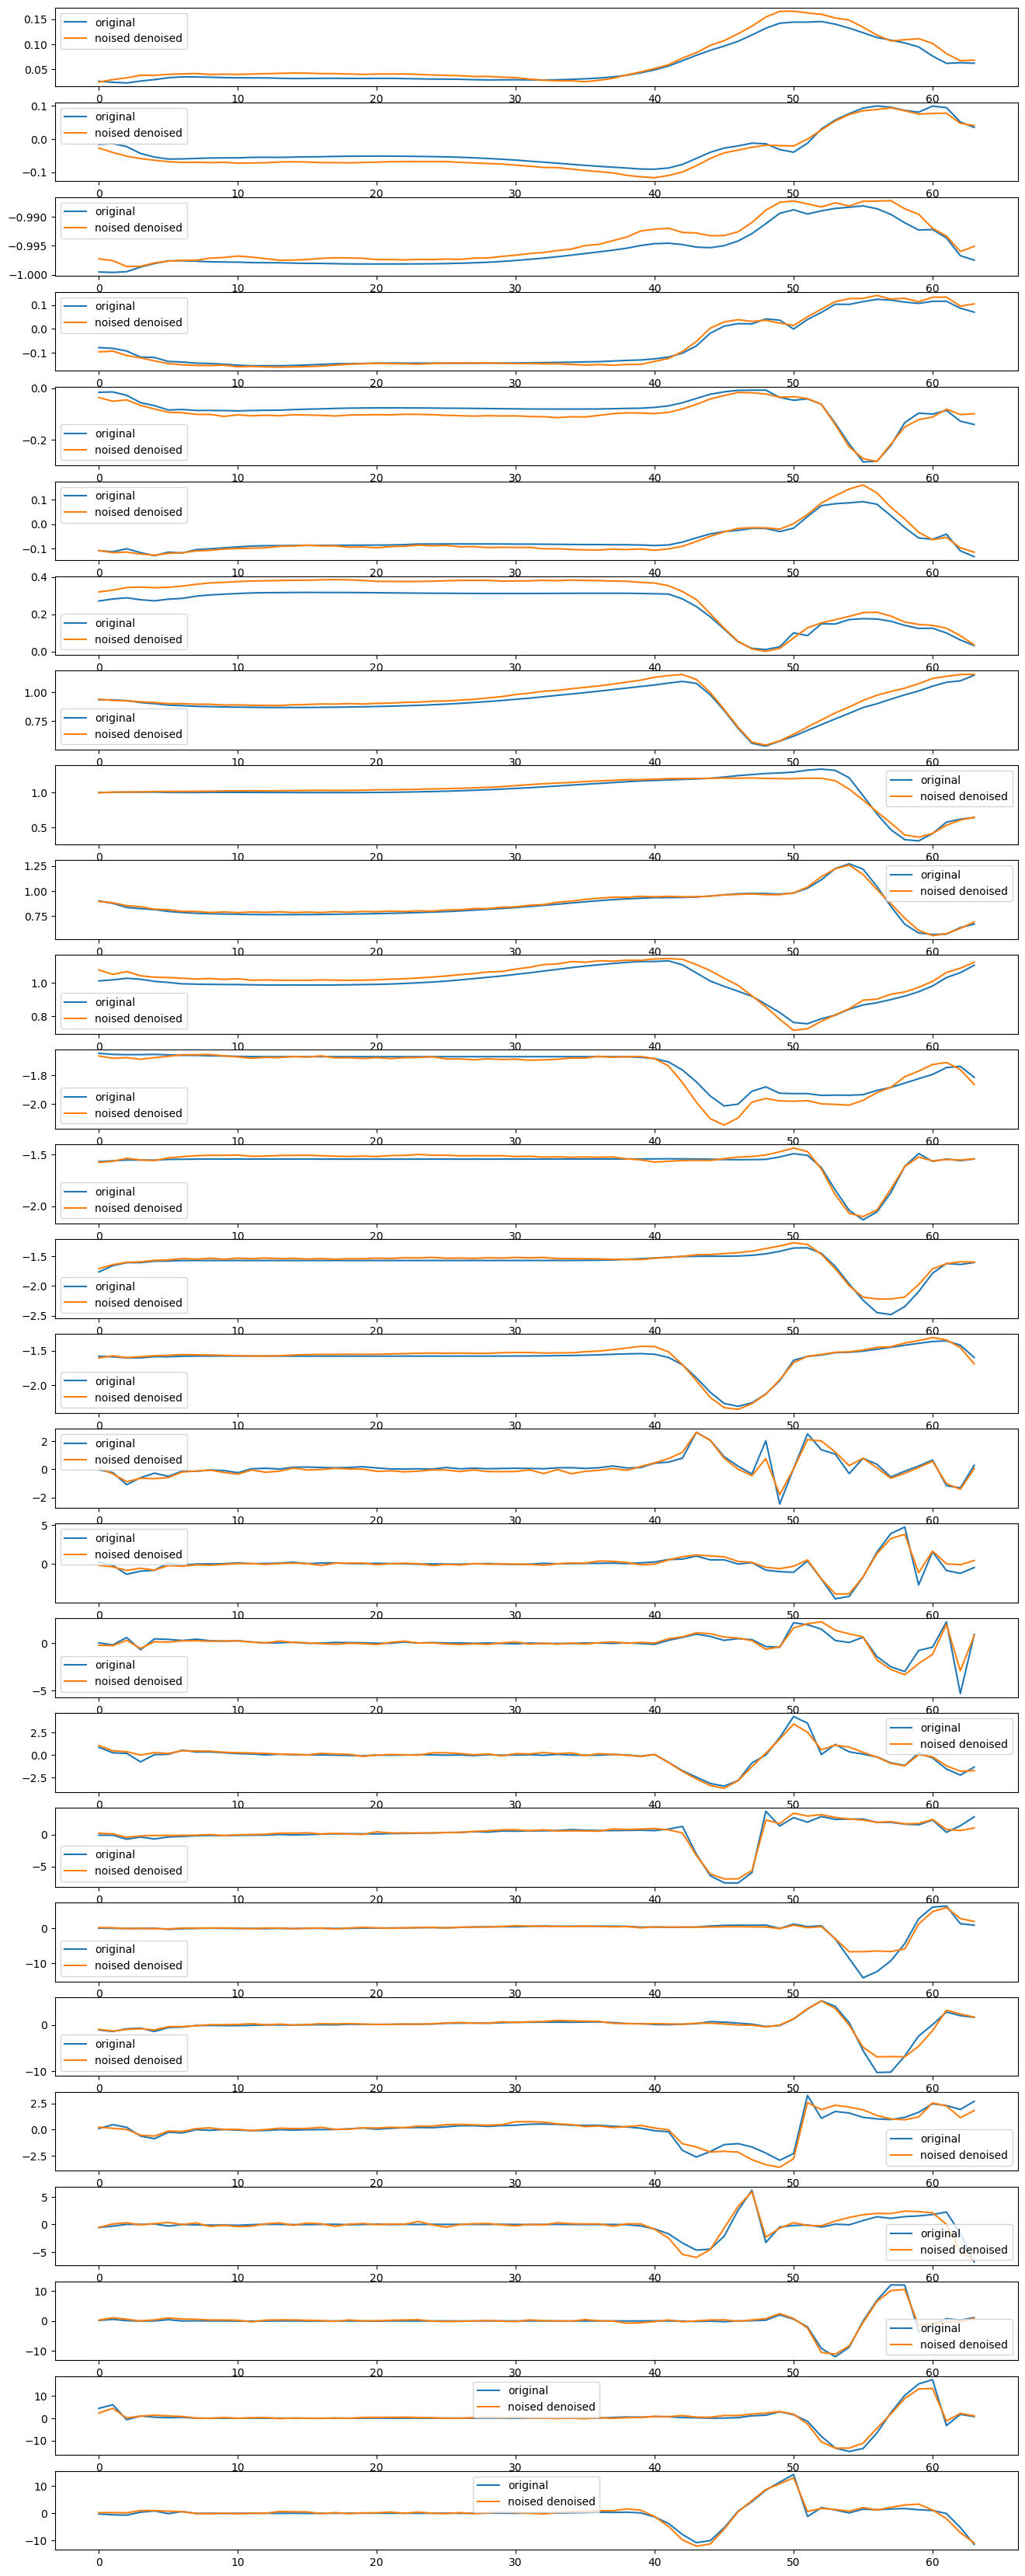

In [72]:
device = "cuda"

@torch.inference_mode()
def denoise(batch: torch.Tensor, steps=5):
    s = model.normalize(batch)
    noise_scheduler.set_timesteps(100)
    for t in noise_scheduler.timesteps[-steps:]:
        model_output = model(s, t.to(device).expand(batch.shape[0]))
        s = noise_scheduler.step(model_output, t, s).prev_sample
    return model.denormalize(s)

@torch.inference_mode()
def noise_denoise(batch: torch.Tensor, steps=5):
    s = model.normalize(batch)
    noise_scheduler.set_timesteps(100)

    noise = torch.randn_like(s)
    s = noise_scheduler.add_noise(s, noise, torch.tensor(steps))

    for t in noise_scheduler.timesteps[-steps:]:
        model_output = model(s, t.to(device).expand(batch.shape[0]))
        s = noise_scheduler.step(model_output, t, s).prev_sample
    return model.denormalize(s)

from scipy.spatial.transform import Rotation as R

rpy = dataset["rpy"][start: end]
gravity = R.from_euler("xyz", rpy).inv().apply(torch.tensor([0., 0., -1.]))
gravity = torch.asarray(gravity).to(device)
jpos = torch.asarray(jpos).to(device)
jvel = torch.asarray(jvel).to(device)

batch = torch.cat([gravity, jpos, jvel], dim=-1).T.float().unsqueeze(0)
ndim = 27
batch_denoised = denoise(batch, steps=10)
batch_noised_denoised = noise_denoise(batch, steps=20)

fig, axes = plt.subplots(ndim, 1, figsize=(16, 2 + ndim * 1.5))

for i in range(ndim):
    axes[i].plot(batch[0, i].cpu(), label="original")
    # axes[i].plot(batch_denoised[0, i].cpu(), label="denoised")
    axes[i].plot(batch_noised_denoised[0, i].cpu(), label="noised denoised")
    axes[i].legend()

In [34]:
batch.shape

torch.Size([27, 64])